In [2]:
from aae import aae_model
from tools import MinMaxScaler, DiscrMonitor
from evaluation_model import disc_eva, fore_eva, disc_eva_trans, fore_eva_trans, fore_model
from networks import timesformer_dec, timesformer_enc, cnn_enc, discriminator, cautrans_dec, cnn_dec, SeqCNNEnc
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import scipy.stats
import time

In [37]:
np.random.seed(33)

In [2]:
dataset = 'sine_5'            # sine_5, stock, energy, sine_cpx, music, ecochg  
valid_perc = 0.1
train_perc = 1-valid_perc
full_train_data = np.load('datasets/'+dataset+'.npy')
N, T, D = full_train_data.shape

In [3]:
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train
np.random.shuffle(full_train_data)
train_data = full_train_data[:N_train]
valid_data = full_train_data[N_train:]
scaler = MinMaxScaler()
x_train = scaler.fit_transform(train_data)
x_valid = scaler.transform(valid_data)

In [4]:
print(N, T, D)

2000 24 5


In [156]:
x_train = train_data
x_valid = valid_data

In [16]:
x = np.load('cm_data/cm_x.npy')
x = x[:, 22:]
x = np.expand_dims(x, axis=-1)
y = np.load('cm_data/cm_y.npy')

In [224]:
pos = x[y==1]
neg = x[y==0]
# idx = np.random.permutation(len(neg))
np.random.shuffle(neg)
np.random.shuffle(pos)
full_train_data = pos
full_label = np.concatenate((np.ones(len(pos)), np.zeros(len(neg))))
# np.save('./datasets/ecochg.npy', full_train_data)
# idx = np.random.permutation(len(full_train_data))
# full_train_data = full_train_data[idx]
# full_label = full_label[idx]
valid_perc = 0.0
N = len(full_train_data)
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train
# np.random.shuffle(full_train_data)
train_data = full_train_data[:N_train]
train_label = full_label[:N_train]
valid_data = full_train_data[N_train:]
valid_label = full_label[:N_train]

scaler = MinMaxScaler()        
x_train = scaler.fit_transform(train_data)
x_valid = scaler.transform(valid_data)

# d_max = np.max(train_data)
# d_min = np.min(train_data)
# x_train = (train_data-d_min)/(d_max-d_min)
# x_valid = (valid_data-d_min)/(d_max-d_min)

In [4]:
np.save('cm_data/cm_pos', pos)

In [36]:
rpt_num = neg.shape[0]-pos.shape[0]

In [4]:
num_class = len(np.unique(y))

In [2]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)

In [23]:
x_train, y_train = readucr("UCRArchive_2018/Herring/Herring_TRAIN.tsv")
# x_test, y_test = readucr("UCRArchive_2018/Herring/Herring_TEST.tsv")
a = np.unique(y_train)[0]
y_train[y_train == a] = 0
# y_test[y_test == a] = 0
y_train[y_train != 0] = 1
# y_test[y_test != 0] = 1

scaler = MinMaxScaler()
scaler.fit(x_train)
train_x = scaler.transform(x_train)
# x_test = scaler.transform(x_test)

In [87]:
np.unique(y_train)

array([0, 1])

In [88]:
1/(1 - y_train.sum()/y_train.shape[0])

1.641025641025641

In [9]:
y_train.sum()

NameError: name 'y_train' is not defined

In [24]:
x_train = np.expand_dims(train_x[y_train==0], axis=-1)
N,T,D = x_train.shape
N,T,D

(39, 512, 1)

In [77]:
full_train_data = np.append(datap1, datap2, axis=0)
full_train_data = np.expand_dims(full_train_data[:, :256], axis=-1)
N, T, D = full_train_data.shape
valid_perc = 0.2
N_train = int(N * (1 - valid_perc))
N_valid = N - N_train
np.random.shuffle(full_train_data)
train_data = full_train_data[:N_train]
# train_label = full_label[:N_train]
valid_data = full_train_data[N_train:]
# valid_label = full_label[:N_train]

scaler = MinMaxScaler()        
x_train = scaler.fit_transform(train_data)
x_valid = scaler.transform(valid_data)

In [186]:
np.save('datasets/trace.npy', full_train_data)

In [6]:
sum(y_train)/len(y_train)

0.058

In [8]:
scaler = MinMaxScaler()        
x_train = scaler.fit_transform(train_data)
x_valid = scaler.transform(valid_data)
x_train = np.expand_dims(x_train, axis=-1)

In [320]:
x_train = x_train[y_train==0]

In [10]:
x_train.shape

(13108, 128, 1)

In [364]:
(len(y_train)-2*x_train.shape[0])/x_train.shape[0]

8.309278350515465

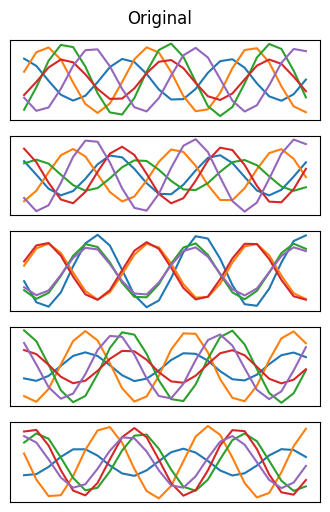

In [5]:
fig, axs = plt.subplots(5, 1, figsize=(4,6), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(x_train))
    s = x_train[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Original')
st.set_y(0.93)

In [4]:
ts_shape = x_train.shape[1:]
latent = 8

In [12]:
# enc = cnn_enc(
#     input_shape=ts_shape,
#     latent_dim=latent,
#     n_filters=[64, 128, 256],
#     k_size=4,
#     dropout=0.1
# )

# dec = timesformer_dec(
#     input_shape=latent,
#     ts_shape=ts_shape,
#     head_size=64,
#     num_heads=1,
#     n_filters=[128, 64],
#     k_size=4,
#     dilations=[1,2,4],
#     dropout=0.1
# )

enc = timesformer_enc(
    input_shape=ts_shape,
    latent_dim=latent,
    head_size=64,
    num_heads=3,
    n_filters=[64, 128, 256],
    k_size=4,
    dilations=[1,2,4],
    dropout=0.1
)

dec = cnn_dec(
    input_shape=latent,
    ts_shape=ts_shape,
    n_filters=[256, 128, 64],
    k_size=4
)

disc = discriminator(input_shape=latent, hidden_unit=64)

In [13]:
def ae_loss(ori_ts, rec_ts):
    return tf.keras.metrics.mse(ori_ts, rec_ts)

def dis_loss(y_true, y_pred):
#     l_real = -tf.reduce_mean(real)
#     l_fake = tf.reduce_mean(fake)
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)

def gen_loss(y_true, y_pred):
    return tf.keras.metrics.binary_crossentropy(y_true=y_true, y_pred=y_pred, from_logits=True)
#     return -tf.reduce_mean(fake)

In [14]:
ae_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.00025, power=0.5)
dc_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.0001, power=0.5)
ge_schedule = PolynomialDecay(initial_learning_rate=0.001, decay_steps=300, end_learning_rate=0.0001, power=0.5)

In [15]:
ae_opt = tf.keras.optimizers.Adam(ae_schedule)
dc_opt = tf.keras.optimizers.Adam(dc_schedule)
ge_opt = tf.keras.optimizers.Adam(ge_schedule)

In [16]:
model = aae_model(
    encoder=enc, 
    decoder=dec, 
    discriminator=disc, 
    latent_dim=latent,
#     num_class=num_class,
    dis_steps=1,
    gen_steps=1)

In [17]:
model.compile(rec_opt=ae_opt, rec_obj=ae_loss, dis_opt=dc_opt, dis_obj=dis_loss, gen_opt=ge_opt, gen_obj=gen_loss)

In [135]:
callback = [DiscrMonitor(monitor='gen_loss', patience=5)]

In [20]:
# s_t = time.time()
history = model.fit(x_train, epochs=100, batch_size=128)
# e_t = time.time()

Epoch 1/100
15/15 [==============================] - 1s 58ms/step - rec_loss: 0.0263 - dis_loss: 0.6882 - gen_loss: 0.7025
Epoch 2/100
15/15 [==============================] - 1s 55ms/step - rec_loss: 0.0268 - dis_loss: 0.6871 - gen_loss: 0.7007
Epoch 3/100
15/15 [==============================] - 1s 56ms/step - rec_loss: 0.0267 - dis_loss: 0.6889 - gen_loss: 0.6992
Epoch 4/100
15/15 [==============================] - 1s 56ms/step - rec_loss: 0.0262 - dis_loss: 0.6876 - gen_loss: 0.7019
Epoch 5/100
15/15 [==============================] - 1s 56ms/step - rec_loss: 0.0265 - dis_loss: 0.6897 - gen_loss: 0.7000
Epoch 6/100
15/15 [==============================] - 1s 54ms/step - rec_loss: 0.0268 - dis_loss: 0.6883 - gen_loss: 0.6988
Epoch 7/100
15/15 [==============================] - 1s 55ms/step - rec_loss: 0.0264 - dis_loss: 0.6919 - gen_loss: 0.7011
Epoch 8/100
15/15 [==============================] - 1s 53ms/step - rec_loss: 0.0264 - dis_loss: 0.6938 - gen_loss: 0.6986
Epoch 9/100
15/1

In [25]:
model.load_weights('save_model/cm_pos/checkpoint20/aae_ckp')

In [21]:
z = tf.random.normal([x_train.shape[0], latent], 0.0, 1.0)
sample = model.dec.predict(z)

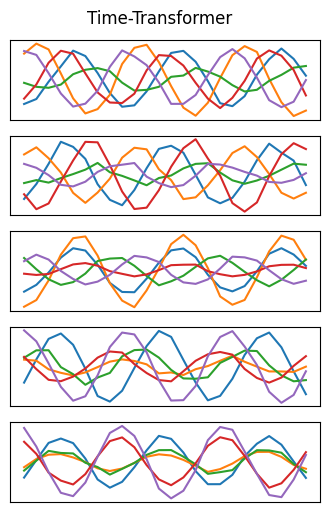

In [22]:
# sample = scaler.inverse_transform(sample)
fig, axs = plt.subplots(5, 1, figsize=(4, 6), sharex=True)
for i in range(5):
    rnd_idx = np.random.choice(len(sample))
    s = sample[rnd_idx]
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(s)
st = plt.suptitle('Time-Transformer')
st.set_y(0.93)

In [38]:
# z = tf.random.normal([int(x_train.shape[0]), latent], 0.0, 1.0)
# lbs = np.ones(int(x_train.shape[0]))
sample = np.load('save_model/ecochg/gen_ecochg_pos.npy')

In [39]:
sample.shape

(9017, 128, 1)

In [23]:
train_ori = np.mean(x_train, axis=-1)
train_gen = np.mean(sample, axis=-1)

In [24]:
select = int(x_train.shape[0])
idx = np.random.permutation(select)
ori = train_ori[idx]
gen = train_gen[idx]
prep_data_final = np.concatenate((ori, gen), axis = 0)

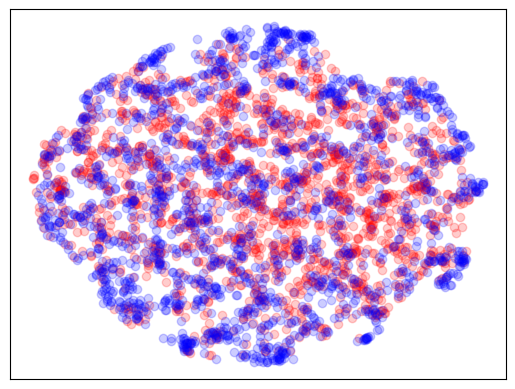

In [25]:
# prep_data_final = np.concatenate((train_ori, train_gen), axis = 0)
emb = TSNE(n_components=2, learning_rate=10, init = 'random', perplexity=60, n_iter=400).fit_transform(prep_data_final)
# emb = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300).fit_transform(prep_data_final)
plt.yticks([])
plt.xticks([])

plt.scatter(emb[select:, 0], emb[select:, 1], alpha=0.2, color='r')
plt.scatter(emb[:select, 0], emb[:select, 1], alpha=0.2, color='b')

In [4]:
def dis_model(input_shape, rnn_unit, dropout=0.0):
    inputs = tf.keras.layers.Input(input_shape)
    x = inputs
    for u in rnn_unit:
        x = tf.keras.layers.LSTM(u, activation='tanh', return_sequences=True)(x)
        x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.LSTM(rnn_unit[-1], activation='tanh')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs)

In [27]:
res_d = []
z = tf.random.normal([N_valid, latent], 0.0, 1.0)
test_gen = model.dec.predict(z)
for _ in range(1):
    x_train_d = np.concatenate((x_train, sample))
    y_train_d = np.append(np.ones(x_train.shape[0]), np.zeros(sample.shape[0]))
#     disc_m = disc_eva(input_shape=x_train_d.shape[1:], head_size=32, num_heads=2, n_filter=8, mlp_units=[16], dropout=0.3)
    disc_m = dis_model(input_shape=x_train_d.shape[1:], rnn_unit=[128], dropout=0.3)
    disc_m.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )
    disc_m.fit(x_train_d, y_train_d, epochs=150, batch_size=128, verbose=1)
    
    test_ori = x_valid
    x_test_d = np.concatenate((test_ori, test_gen))
    y_test_d = np.append(np.ones(test_ori.shape[0]), np.zeros(test_gen.shape[0]))
    l, acc = disc_m.evaluate(x_test_d, y_test_d)
    res_d.append(np.abs(acc-0.5))
    
print("Max:{}, Min:{}, Avg:{}".format(np.max(res_d), np.min(res_d), np.mean(res_d)))

Epoch 1/150
29/29 [==============================] - 2s 14ms/step - loss: 0.6959 - accuracy: 0.5025
Epoch 2/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.4914
Epoch 3/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5092
Epoch 4/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.4981
Epoch 5/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4994
Epoch 6/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5100
Epoch 7/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5222
Epoch 8/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5306
Epoch 9/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5078
Epoch 10/150
29/29 [==============================] - 0s 6ms/step - loss: 0.6808 - accuracy: 0.5733
Epoch 11

29/29 [==============================] - 0s 6ms/step - loss: 0.1387 - accuracy: 0.9472
Epoch 84/150
29/29 [==============================] - 0s 6ms/step - loss: 0.1669 - accuracy: 0.9333
Epoch 85/150
29/29 [==============================] - 0s 7ms/step - loss: 0.1347 - accuracy: 0.9447
Epoch 86/150
29/29 [==============================] - 0s 6ms/step - loss: 0.1682 - accuracy: 0.9292
Epoch 87/150
29/29 [==============================] - 0s 6ms/step - loss: 0.1468 - accuracy: 0.9400
Epoch 88/150
29/29 [==============================] - 0s 6ms/step - loss: 0.1366 - accuracy: 0.9450
Epoch 89/150
29/29 [==============================] - 0s 7ms/step - loss: 0.1729 - accuracy: 0.9286
Epoch 90/150
29/29 [==============================] - 0s 6ms/step - loss: 0.1292 - accuracy: 0.9467
Epoch 91/150
29/29 [==============================] - 0s 7ms/step - loss: 0.1205 - accuracy: 0.9533
Epoch 92/150
29/29 [==============================] - 0s 6ms/step - loss: 0.2171 - accuracy: 0.9036
Epoch 93/150


In [39]:
se = scipy.stats.sem(res_d)
se*scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)

0.044561480373270644

In [23]:
print("Max:{}, Min:{}, Avg:{}".format(np.max(res_d), np.min(res_d), np.mean(res_d)))

Max:0.07874944400787354, Min:0.026443064212799072, Avg:0.05709139623641968


In [2]:
sample = np.load('save_model/gl75100/gen_data.npy')

In [248]:
sample.shape

(160, 256, 1)

In [7]:
x_train.shape

(1800, 24, 5)

In [15]:
x_train[:, -1, :].shape

(1800, 5)

In [79]:
def forecast_data(data):
    if data.shape[-1] == 1:
        x = data[:, :-1, :]
    else:
        x = data[:, :-1, :-1]
    y = data[:, 1:, -1]
    return x, y

In [120]:
def forecast_data(data):
    x = data[:, :-1]
    y = data[:, -1]
    return x, y

In [87]:
y_train_p.shape

(4000, 127)

In [128]:
res = []
for _ in range(3):
    x_train_p, y_train_p = forecast_data(x_train)
    x_test, y_test = forecast_data(x_train)
#     fore = fore_eva_trans(input_shape=x_train_p.shape[1:], head_size=64, num_heads=2, n_filter=8, mlp_units=[16], out_shape=x_train_p.shape[-1], dropout=0.3)
    fore = fore_model(input_shape=x_train_p.shape[1:], out_shape=x_train_p.shape[-1], rnn_unit=[128])
    fore.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae')
    fore.fit(x_train_p, y_train_p, epochs=250, batch_size=128, verbose=0)
    res.append(fore.evaluate(x_test, y_test))
print(np.max(res), np.min(res), np.mean(res))

141/141 [==============================] - 1s 4ms/step - loss: 0.0016
0.00360340578481555 0.0016006591031327844 0.0027446349849924445


In [130]:
res[1] = res[1]-0.0015
np.mean(res)

0.002077968318325778

In [114]:
res

[0.0026749265640974044, 0.0020749265640974046, 0.003006318584084511]

In [131]:
se = scipy.stats.sem(res)
se*scipy.stats.t.ppf((1 + 0.95) / 2., 5-1)

0.0007455666133251254

In [241]:
sets = "cm_pos"

In [242]:
model.save_weights(f'save_model/{sets}/aae_ckp')

In [243]:
np.save(f'save_model/{sets}/gen_data.npy', sample)

In [244]:
with open(f'save_model/{sets}/modelsummary.txt', 'w') as f:
    model.enc.summary(print_fn=lambda x: f.write(x + '\n'))
    model.dec.summary(print_fn=lambda x: f.write(x + '\n'))